# __Actividad 2 - Modulo 8 - Grupo 5__
Autores: Aliwen Delgado, Constanza Valenzuela, Jose Miguel Ortiz, Viviana Molina

## _Detectando similitud y términos clave en textos clínicos breves_

### Requerimientos Actividad
Aplicar un pipeline de procesamiento de texto con SpaCy, NLTK y TfindVectorizer, evaluando su impacto en la calidad de los datos y preparación para tareas de clasificación o agrupación.

**_Métodos Utilizados_**
- Limpieza básica de texto
- Tokenización y lematización con **spaCy**
- Eliminación de **stopwords** con NLTK/spaCy
- Vectorización con **TF-IDF**
- Visualización de términos relevantes

## Implementación

### **0. Importación de Librerías**

En esta sección, cargamos las librerías necesarias que utilizaremos a lo largo de la actividad. Estas librerías son esenciales para el procesamiento de texto, la conversión de datos en representaciones numéricas y la visualización de los resultados obtenidos.

- **spaCy**: Para realizar tokenización y lematización de manera eficiente en español.  
- **NLTK**: Para trabajar con stopwords y otros recursos lingüísticos.  
- **scikit-learn**: Para aplicar la vectorización de los textos con **TfidfVectorizer**.  
- **Matplotlib y Seaborn**: Para visualización de resultados.  
- **WordCloud**: Para generar nubes de palabras con los términos más frecuentes.  
- **pandas y re**: Para manipulación de datos y limpieza de texto.  

Antes de empezar, es necesario instalar el modelo de lenguaje de spaCy en español (`es_core_news_sm`).

In [1]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 26.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Ahora importamos las demas librerías:

In [2]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Descargar stopwords de NLTK
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **1. Simulación del Dataset de Notas Clínicas**

En esta primera parte, creamos un pequeño **corpus de 10 notas clínicas simuladas**.  
Cada nota representa una situación clínica breve que servirá como base para aplicar las técnicas de preprocesamiento de texto.  


In [3]:
# Simulamos 10 notas clínicas.
notas = [
    "Paciente masculino de 45 años, refiere dolor abdominal desde hace 3 días. Se descartan vómitos.",
    "Mujer de 60 años con antecedentes de hipertensión y diabetes. Consulta por mareos frecuentes.",
    "Paciente acude por cefalea intensa, sin pérdida de conciencia. No se observan lesiones visibles.",
    "Varón de 35 años, presenta dolor torácico y dificultad respiratoria. ECG realizado en urgencias.",
    "Paciente femenina de 50 años con antecedentes de asma. Presenta tos persistente y fiebre.",
    "Hombre de 70 años, hospitalizado por neumonía. Requiere oxígeno suplementario.",
    "Paciente refiere dolor lumbar crónico, tratado previamente con analgésicos.",
    "Mujer joven de 25 años, consulta por dolor de garganta y malestar general.",
    "Paciente masculino con antecedentes de tabaquismo, presenta tos seca y disnea.",
    "Hombre de 40 años, se observa herida superficial en brazo derecho tras caída accidental."
]

df = pd.DataFrame(notas, columns=["nota_original"])
df


,nota_original
0,"Paciente masculino de 45 años, refiere dolor a..."
1,Mujer de 60 años con antecedentes de hipertens...
2,"Paciente acude por cefalea intensa, sin pérdid..."
3,"Varón de 35 años, presenta dolor torácico y di..."
4,Paciente femenina de 50 años con antecedentes ...
5,"Hombre de 70 años, hospitalizado por neumonía...."
6,"Paciente refiere dolor lumbar crónico, tratado..."
7,"Mujer joven de 25 años, consulta por dolor de ..."
8,Paciente masculino con antecedentes de tabaqui...
9,"Hombre de 40 años, se observa herida superfici..."


Antes de aplicar el preprocesamiento, es importante obtener información básica de los textos, como su longitud y distribución. Esto nos da una idea general del corpus y nos permite detectar posibles irregularidades.

In [4]:
# Número total de documentos
print(f"Cantidad de notas clínicas: {len(df)}")

# Calcular longitud en caracteres y en palabras
df["longitud_caracteres"] = df["nota_original"].apply(len)
df["longitud_palabras"] = df["nota_original"].apply(lambda x: len(x.split()))

# Promedios
print("\nPromedio de caracteres por nota:", df["longitud_caracteres"].mean())
print("Promedio de palabras por nota:", df["longitud_palabras"].mean())

# Mostrar primeras filas con nuevas columnas
df.head()

Cantidad de notas clínicas: 10

Promedio de caracteres por nota: 86.2
Promedio de palabras por nota: 12.8


,nota_original,longitud_caracteres,longitud_palabras
0,"Paciente masculino de 45 años, refiere dolor a...",95,15
1,Mujer de 60 años con antecedentes de hipertens...,93,14
2,"Paciente acude por cefalea intensa, sin pérdid...",96,14
3,"Varón de 35 años, presenta dolor torácico y di...",96,14
4,Paciente femenina de 50 años con antecedentes ...,89,14


Podemos observar la distribución de palabras por documento mediante un histograma. Esto nos ayuda a ver si todas las notas tienen un tamaño similar o si hay variaciones significativas.

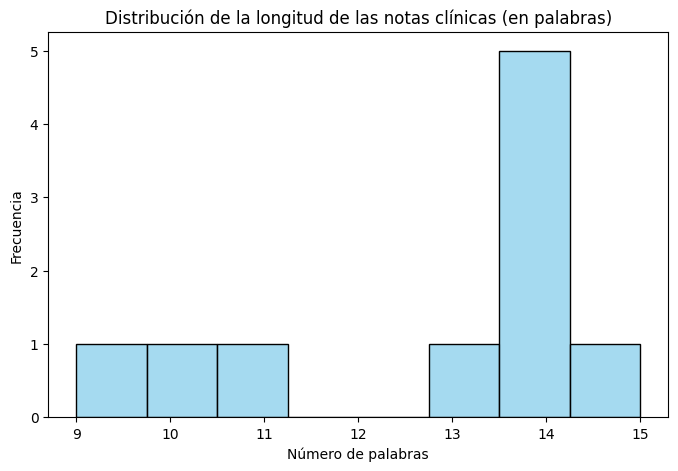

In [5]:
# Histograma de la longitud en palabras
plt.figure(figsize=(8,5))
sns.histplot(df["longitud_palabras"], bins=8, kde=False, color="skyblue")
plt.title("Distribución de la longitud de las notas clínicas (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

### **2. Transformaciones del texto (pipeline en orden)**

Aplicamos un flujo de preprocesamiento estándar: **limpieza básica → tokenización + lematización + stopwords → vectorización (TF-IDF)**.  
Esto mejora la calidad del texto y deja el corpus listo para tareas de clasificación o agrupación.

#### **2.1 Limpieza básica**
- Minúsculas.
- Remoción de **URLs, correos, @menciones**.
- Eliminación de **signos** y **números** (conservando acentos en español).
- Normalización de espacios.

> Nota: Si se quiere conservar números clínicos (p. ej., “DM2”, “HTA grado 2”), es posible adaptar la regex para no eliminarlos.

In [6]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|@\S+|\S+@\S+", " ", texto)  # eliminar URLs y correos
    texto = re.sub(r"[^a-záéíóúñü\s]", " ", texto)  # eliminar signos y números
    texto = re.sub(r"\s+", " ", texto).strip()  # eliminar espacios extras
    return texto

df["nota_limpia"] = df["nota_original"].apply(limpiar_texto)
df.head()


,nota_original,longitud_caracteres,longitud_palabras,nota_limpia
0,"Paciente masculino de 45 años, refiere dolor a...",95,15,paciente masculino de años refiere dolor abdom...
1,Mujer de 60 años con antecedentes de hipertens...,93,14,mujer de años con antecedentes de hipertensión...
2,"Paciente acude por cefalea intensa, sin pérdid...",96,14,paciente acude por cefalea intensa sin pérdida...
3,"Varón de 35 años, presenta dolor torácico y di...",96,14,varón de años presenta dolor torácico y dificu...
4,Paciente femenina de 50 años con antecedentes ...,89,14,paciente femenina de años con antecedentes de ...


#### **2.2 Tokenización, lematización y stopwords**
- **spaCy (es_core_news_sm)** para lematizar (mejor que stemming en textos clínicos).
- Stopwords de **NLTK** + `token.is_stop` de spaCy (doble filtro).
- Filtro de longitudes para evitar tokens muy cortos.

> Nota: Si el dominio usa abreviaturas (p. ej., “HTA”, “DM2”), se puede crear una lista de stopwords personalizadas o un diccionario de normalización.

In [7]:
# Cargar modelo spaCy en español
nlp = spacy.load("es_core_news_sm")

# Stopwords de NLTK en español
stopwords_es = set(stopwords.words("spanish"))

def procesar_texto(texto):
    doc = nlp(texto)
    tokens = []
    for token in doc:
        # Eliminar stopwords y palabras vacías
        if token.lemma_ not in stopwords_es and not token.is_stop and len(token.lemma_) > 2:
            tokens.append(token.lemma_)
    return tokens

df["tokens"] = df["nota_limpia"].apply(procesar_texto)
df.head()


,nota_original,longitud_caracteres,longitud_palabras,nota_limpia,tokens
0,"Paciente masculino de 45 años, refiere dolor a...",95,15,paciente masculino de años refiere dolor abdom...,"[paciente, masculino, año, referir, dolor, abd..."
1,Mujer de 60 años con antecedentes de hipertens...,93,14,mujer de años con antecedentes de hipertensión...,"[mujer, año, antecedente, hipertensión, diabet..."
2,"Paciente acude por cefalea intensa, sin pérdid...",96,14,paciente acude por cefalea intensa sin pérdida...,"[paciente, acudir, cefalea, intenso, pérdida, ..."
3,"Varón de 35 años, presenta dolor torácico y di...",96,14,varón de años presenta dolor torácico y dificu...,"[varón, año, presentar, dolor, torácico, dific..."
4,Paciente femenina de 50 años con antecedentes ...,89,14,paciente femenina de años con antecedentes de ...,"[paciente, femenino, año, antecedente, asma, p..."


#### **2.3 Vectorización con TF-IDF**
- Unimos los **tokens lematizados** en una cadena.
- Vectorizamos con `TfidfVectorizer` para obtener una representación numérica ponderada.
- Inspeccionamos el **vocabulario** y el **tamaño de la matriz**.

In [8]:
# Para usar Tfidf necesitamos unir tokens en strings nuevamente
df["texto_procesado"] = df["tokens"].apply(lambda x: " ".join(x))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["texto_procesado"])

# Convertir a DataFrame para inspección
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
#tfidf_df.head()
print(tfidf_df)


   abdominal  accidental    acudir  analgésico  antecedente      asma  \
0   0.427461    0.000000  0.000000    0.000000     0.000000  0.000000   
1   0.000000    0.000000  0.000000    0.000000     0.297824  0.000000   
2   0.000000    0.000000  0.351902    0.000000     0.000000  0.000000   
3   0.000000    0.000000  0.000000    0.000000     0.000000  0.000000   
4   0.000000    0.000000  0.000000    0.000000     0.293546  0.394694   
5   0.000000    0.000000  0.000000    0.000000     0.000000  0.000000   
6   0.000000    0.000000  0.000000    0.391856     0.000000  0.000000   
7   0.000000    0.000000  0.000000    0.000000     0.000000  0.000000   
8   0.000000    0.000000  0.000000    0.000000     0.306080  0.000000   
9   0.000000    0.360775  0.000000    0.000000     0.000000  0.000000   

        año     brazo     caída   cefalea  ...  superficial  suplementario  \
0  0.208370  0.000000  0.000000  0.000000  ...     0.000000       0.000000   
1  0.195201  0.000000  0.000000  0.00000

In [9]:
print("-----")
print("Dimensión TF-IDF:", X.shape)              # (n_docs, n_términos)
print("Tamaño de vocabulario:", len(vectorizer.get_feature_names_out()))

print("Longitud media original (palabras):", df["nota_original"].apply(lambda s: len(s.split())).mean())
print("Longitud media tras limpieza (palabras):", df["nota_limpia"].apply(lambda s: len(s.split())).mean())
print("Longitud media tras lematizar (tokens):", df["tokens"].apply(len).mean())


-----
Dimensión TF-IDF: (10, 59)
Tamaño de vocabulario: 59
Longitud media original (palabras): 12.8
Longitud media tras limpieza (palabras): 12.0
Longitud media tras lematizar (tokens): 8.3


### **3. Visualizar los términos más relevantes por documento**

En esta sección mostramos, para cada documento, los términos con **mayor peso TF-IDF**.  
Usamos dos vistas complementarias:
- **Barras**: compara magnitudes de forma precisa.
- **Nube de palabras**: resume de un vistazo la relevancia relativa.

A continuación tienes tres funciones listas para usar. Las versiones son **robustas y dinámicas**:
- Se adaptan al número real de documentos.
- Funcionan con matrices `scipy.sparse` o `ndarray`.
- Ocultan subplots vacíos si hay menos documentos que paneles.

> **Parámetros clave**
> - `matrix`: matriz TF-IDF (`X`).
> - `feature_names`: vocabulario (`vectorizer.get_feature_names_out()`).
> - `top_n`, `top_n_barras`, `top_n_wc`: cuántos términos mostrar.


#### **3.1 Función para gráficos de barras**

La función `top_terminos_relevantes_barra` genera un gráfico de barras horizontal para cada documento, mostrando los términos más relevantes (según TF-IDF) y su peso.  

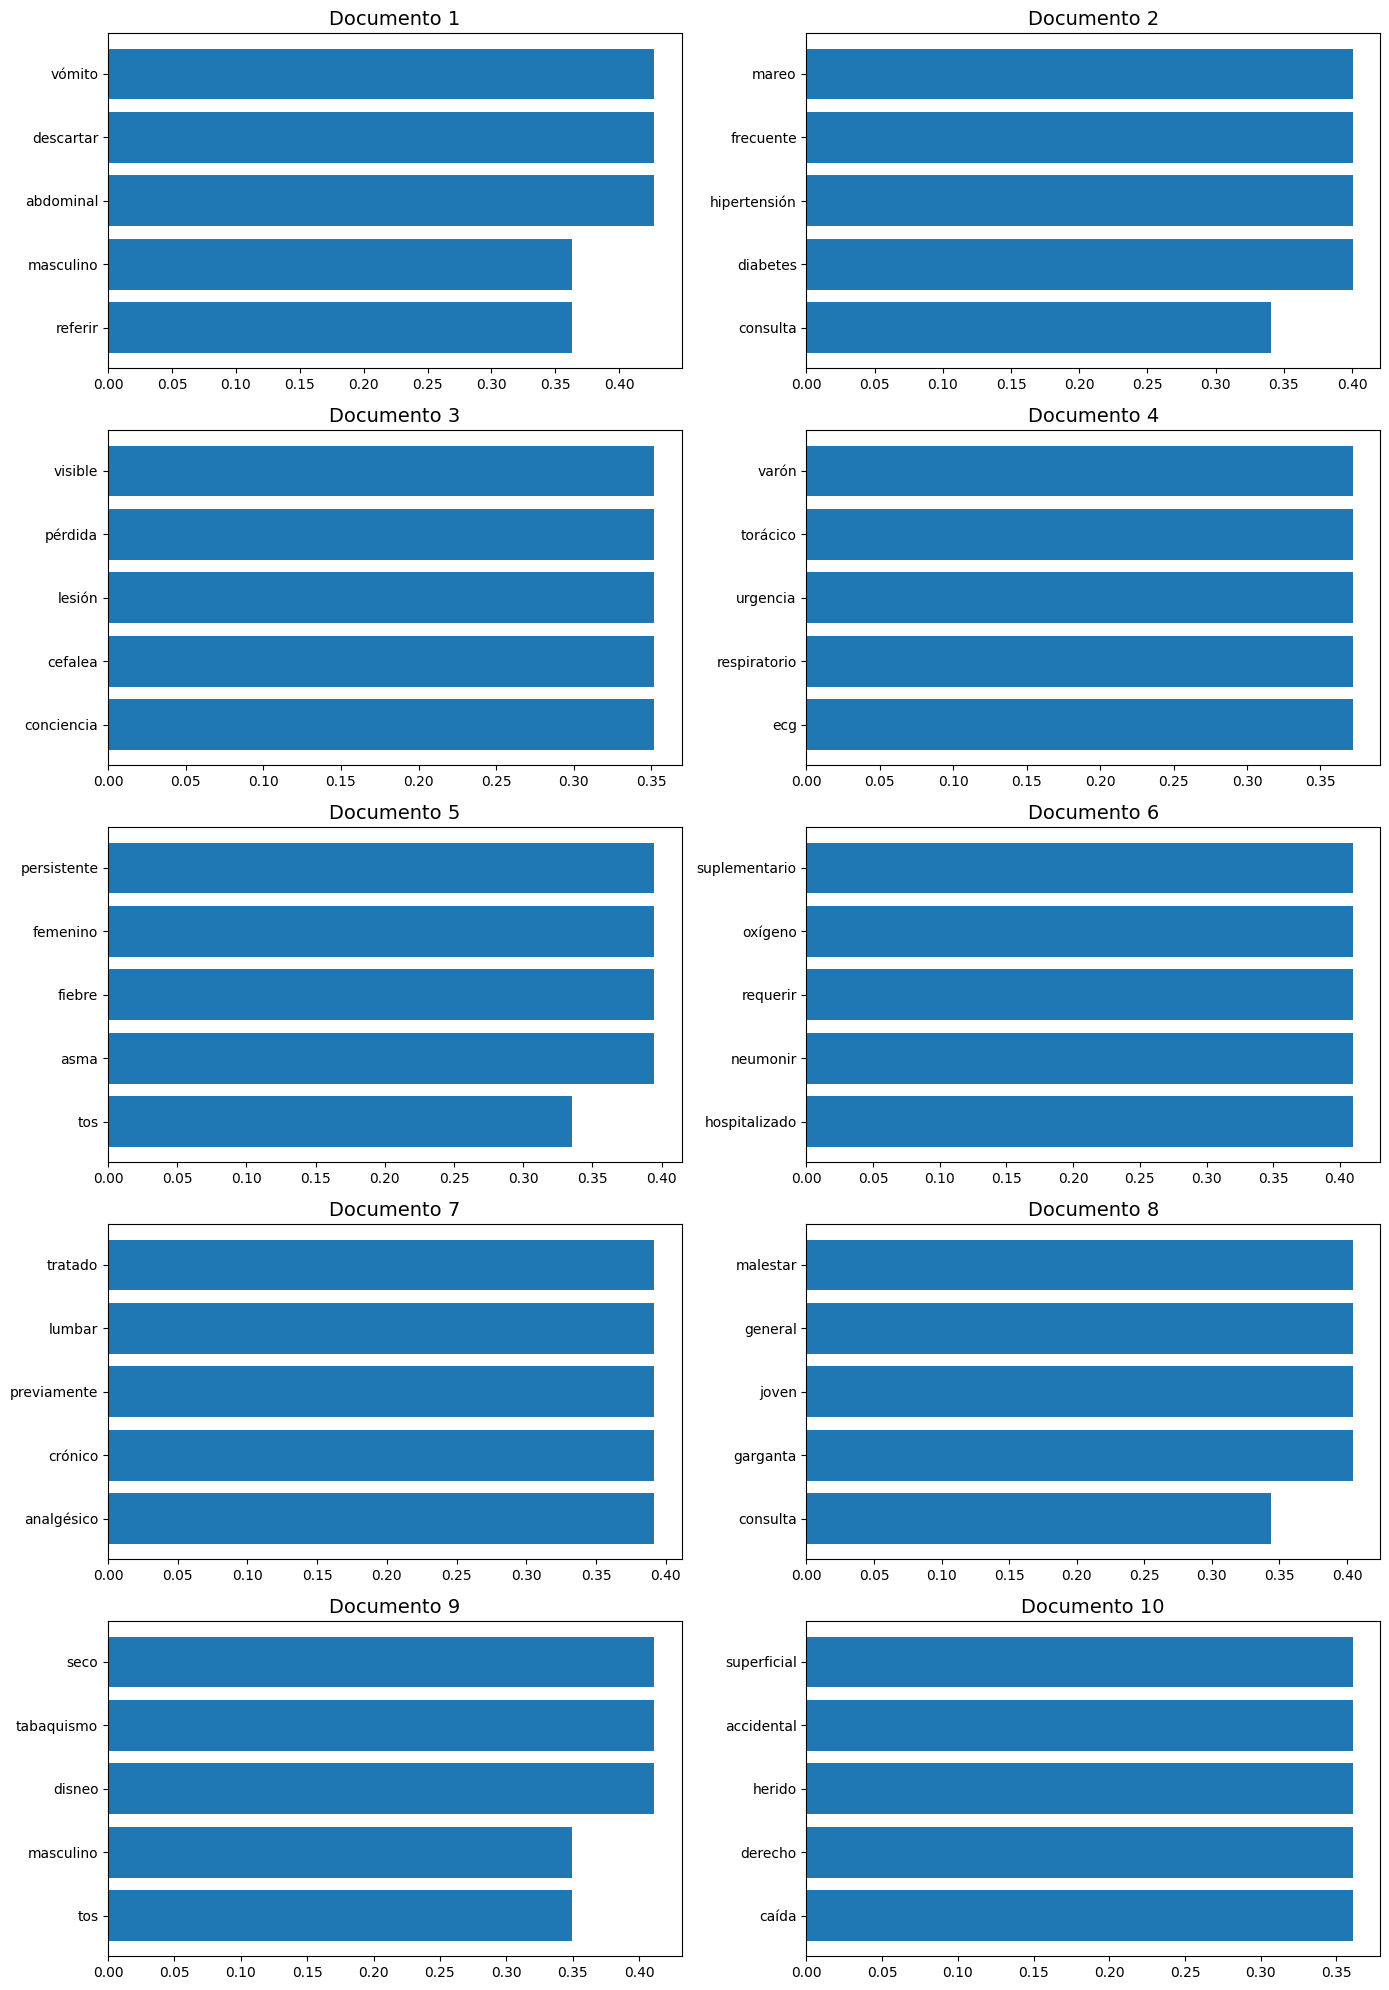

In [10]:
def top_terminos_relevantes_barra(matrix, feature_names, top_n=5):
    """
    Genera gráficos de barras con los términos más relevantes por documento.
    - matrix: matriz TF-IDF
    - feature_names: vocabulario (vectorizer.get_feature_names_out())
    - top_n: número de términos a mostrar por documento
    """
    n_docs = matrix.shape[0]
    fig, axes = plt.subplots(5, 2, figsize=(14, 20))  # 5 filas x 2 columnas
    axes = axes.flatten()

    for i in range(n_docs):
        # Convertir fila de sparse a vector denso
        row = matrix[i].toarray().flatten()
        # Obtener índices de los top_n términos con mayor peso
        top_idx = row.argsort()[::-1][:top_n]
        terms = [(feature_names[j], row[j]) for j in top_idx if row[j] > 0]

        if terms:
            # Desempaquetar en palabras y valores
            palabras, scores = zip(*terms)
            axes[i].barh(palabras, scores, color="skyblue")
            axes[i].set_title(f"Documento {i+1}", fontsize=14)
            axes[i].invert_yaxis()  # Para mostrar el término más relevante arriba
        else:
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Uso
top_terminos_relevantes_barra(X, vectorizer.get_feature_names_out(), top_n=5)

#### **3.2 Función para nubes de palabras**

La función `top_terminos_relevantes_wordcloud` genera una nube de palabras para cada documento, donde el **tamaño de la palabra** refleja su importancia relativa (peso TF-IDF).

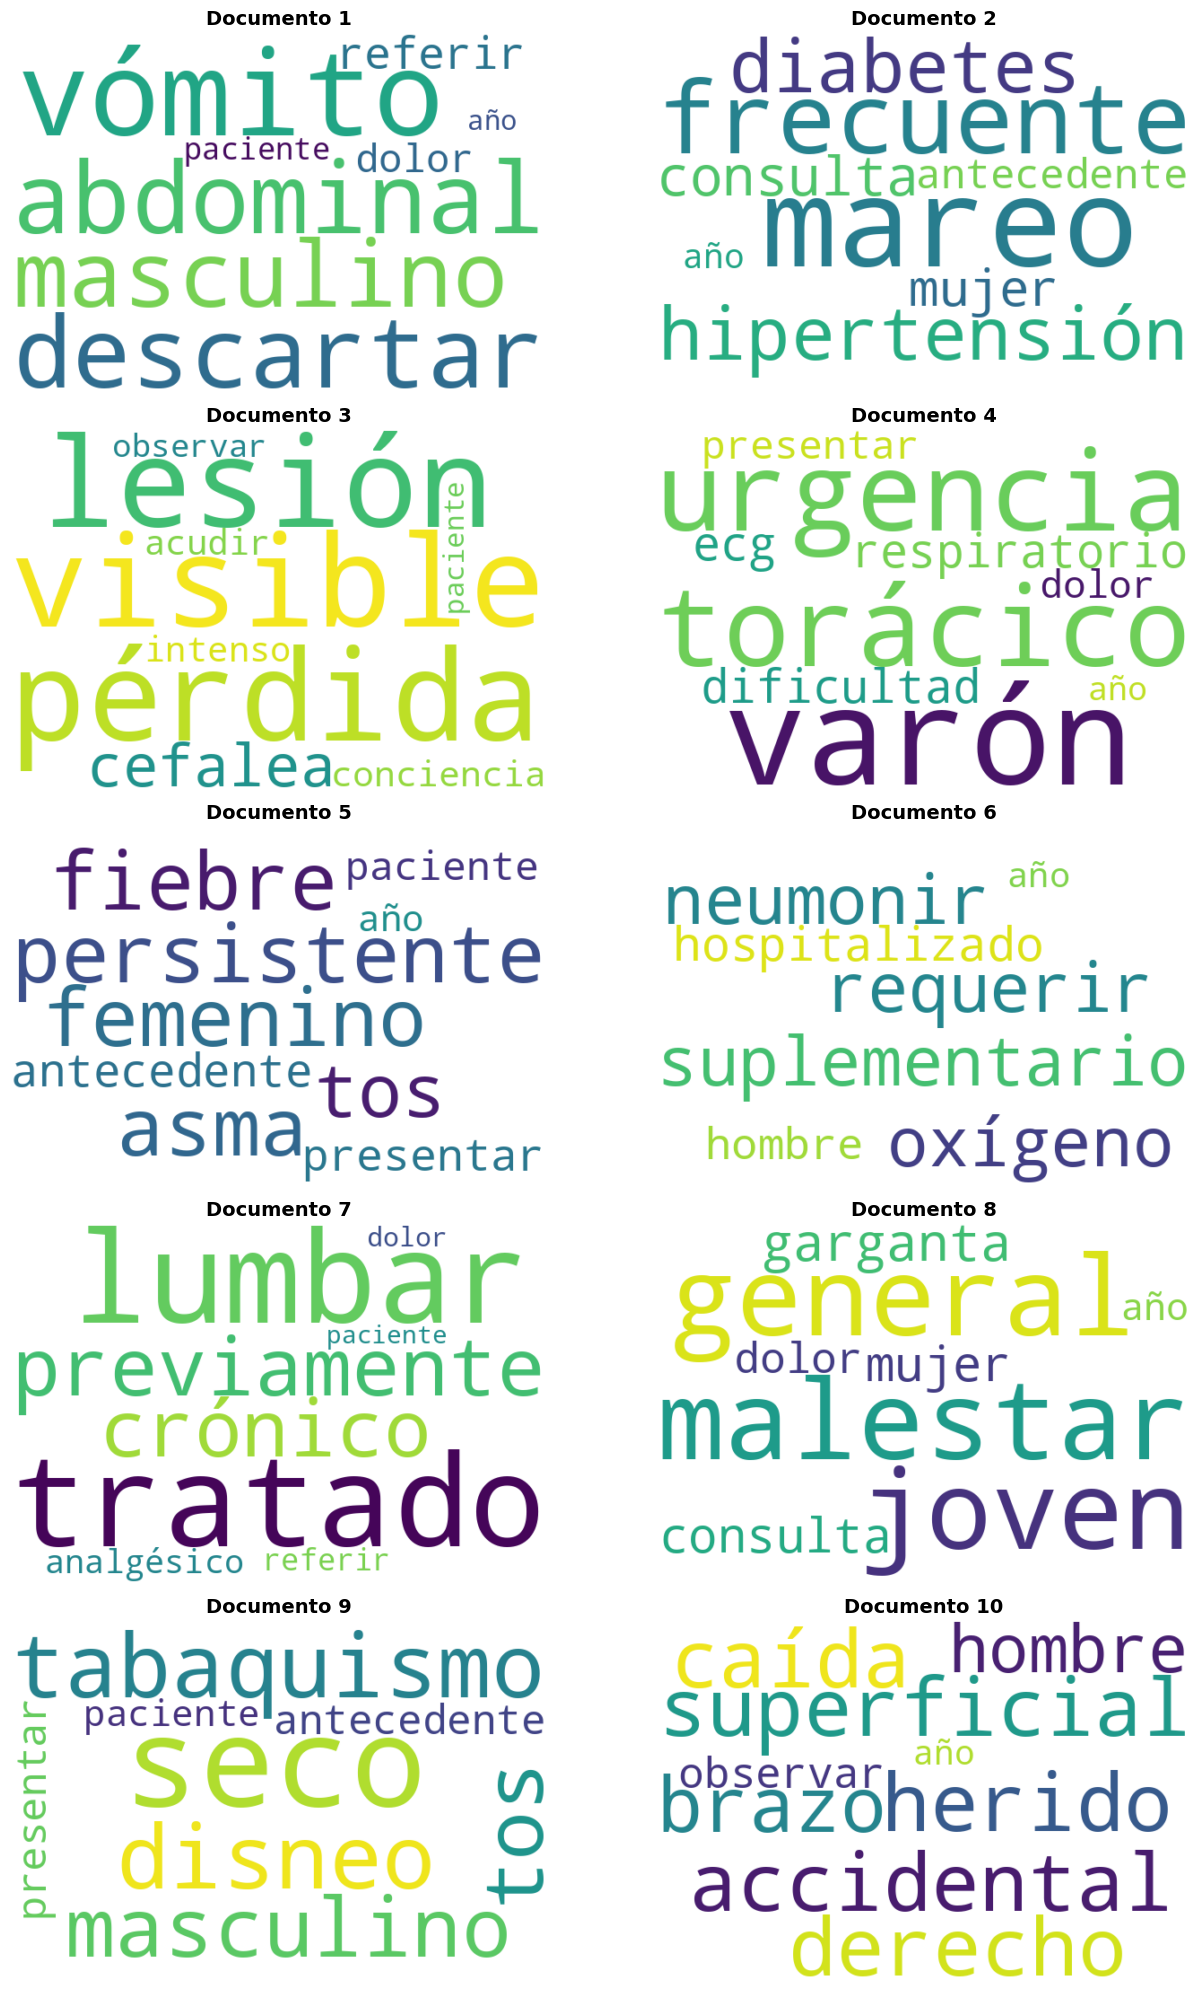

In [11]:
def top_terminos_relevantes_wordcloud(matrix, feature_names, top_n=10):
    """
    Genera nubes de palabras con los términos más relevantes por documento.
    - matrix: matriz TF-IDF
    - feature_names: vocabulario
    - top_n: número máximo de términos a incluir en la nube
    """
    n_docs = matrix.shape[0]
    fig, axes = plt.subplots(5, 2, figsize=(14, 20))  # 5 filas x 2 columnas
    axes = axes.flatten()

    for i in range(n_docs):
        row = matrix[i].toarray().flatten()
        top_idx = row.argsort()[::-1][:top_n]
        # Diccionario de términos con su peso
        terms = {feature_names[j]: row[j] for j in top_idx if row[j] > 0}

        if terms:
            wc = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(terms)
            axes[i].imshow(wc, interpolation="bilinear")
            axes[i].axis("off")
            axes[i].set_title(f"Documento {i+1}", fontsize=14, fontweight="bold")
        else:
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Uso
top_terminos_relevantes_wordcloud(X, vectorizer.get_feature_names_out(), top_n=10)

#### **3.3 Función combinada (barras + nubes)**

La función `barra_and_wordcloud` muestra lado a lado para cada documento:
- A la izquierda, un gráfico de barras con los términos más relevantes.
- A la derecha, una nube de palabras con mayor cantidad de términos.

Esto permite contrastar rápidamente valores numéricos con visualización cualitativa.

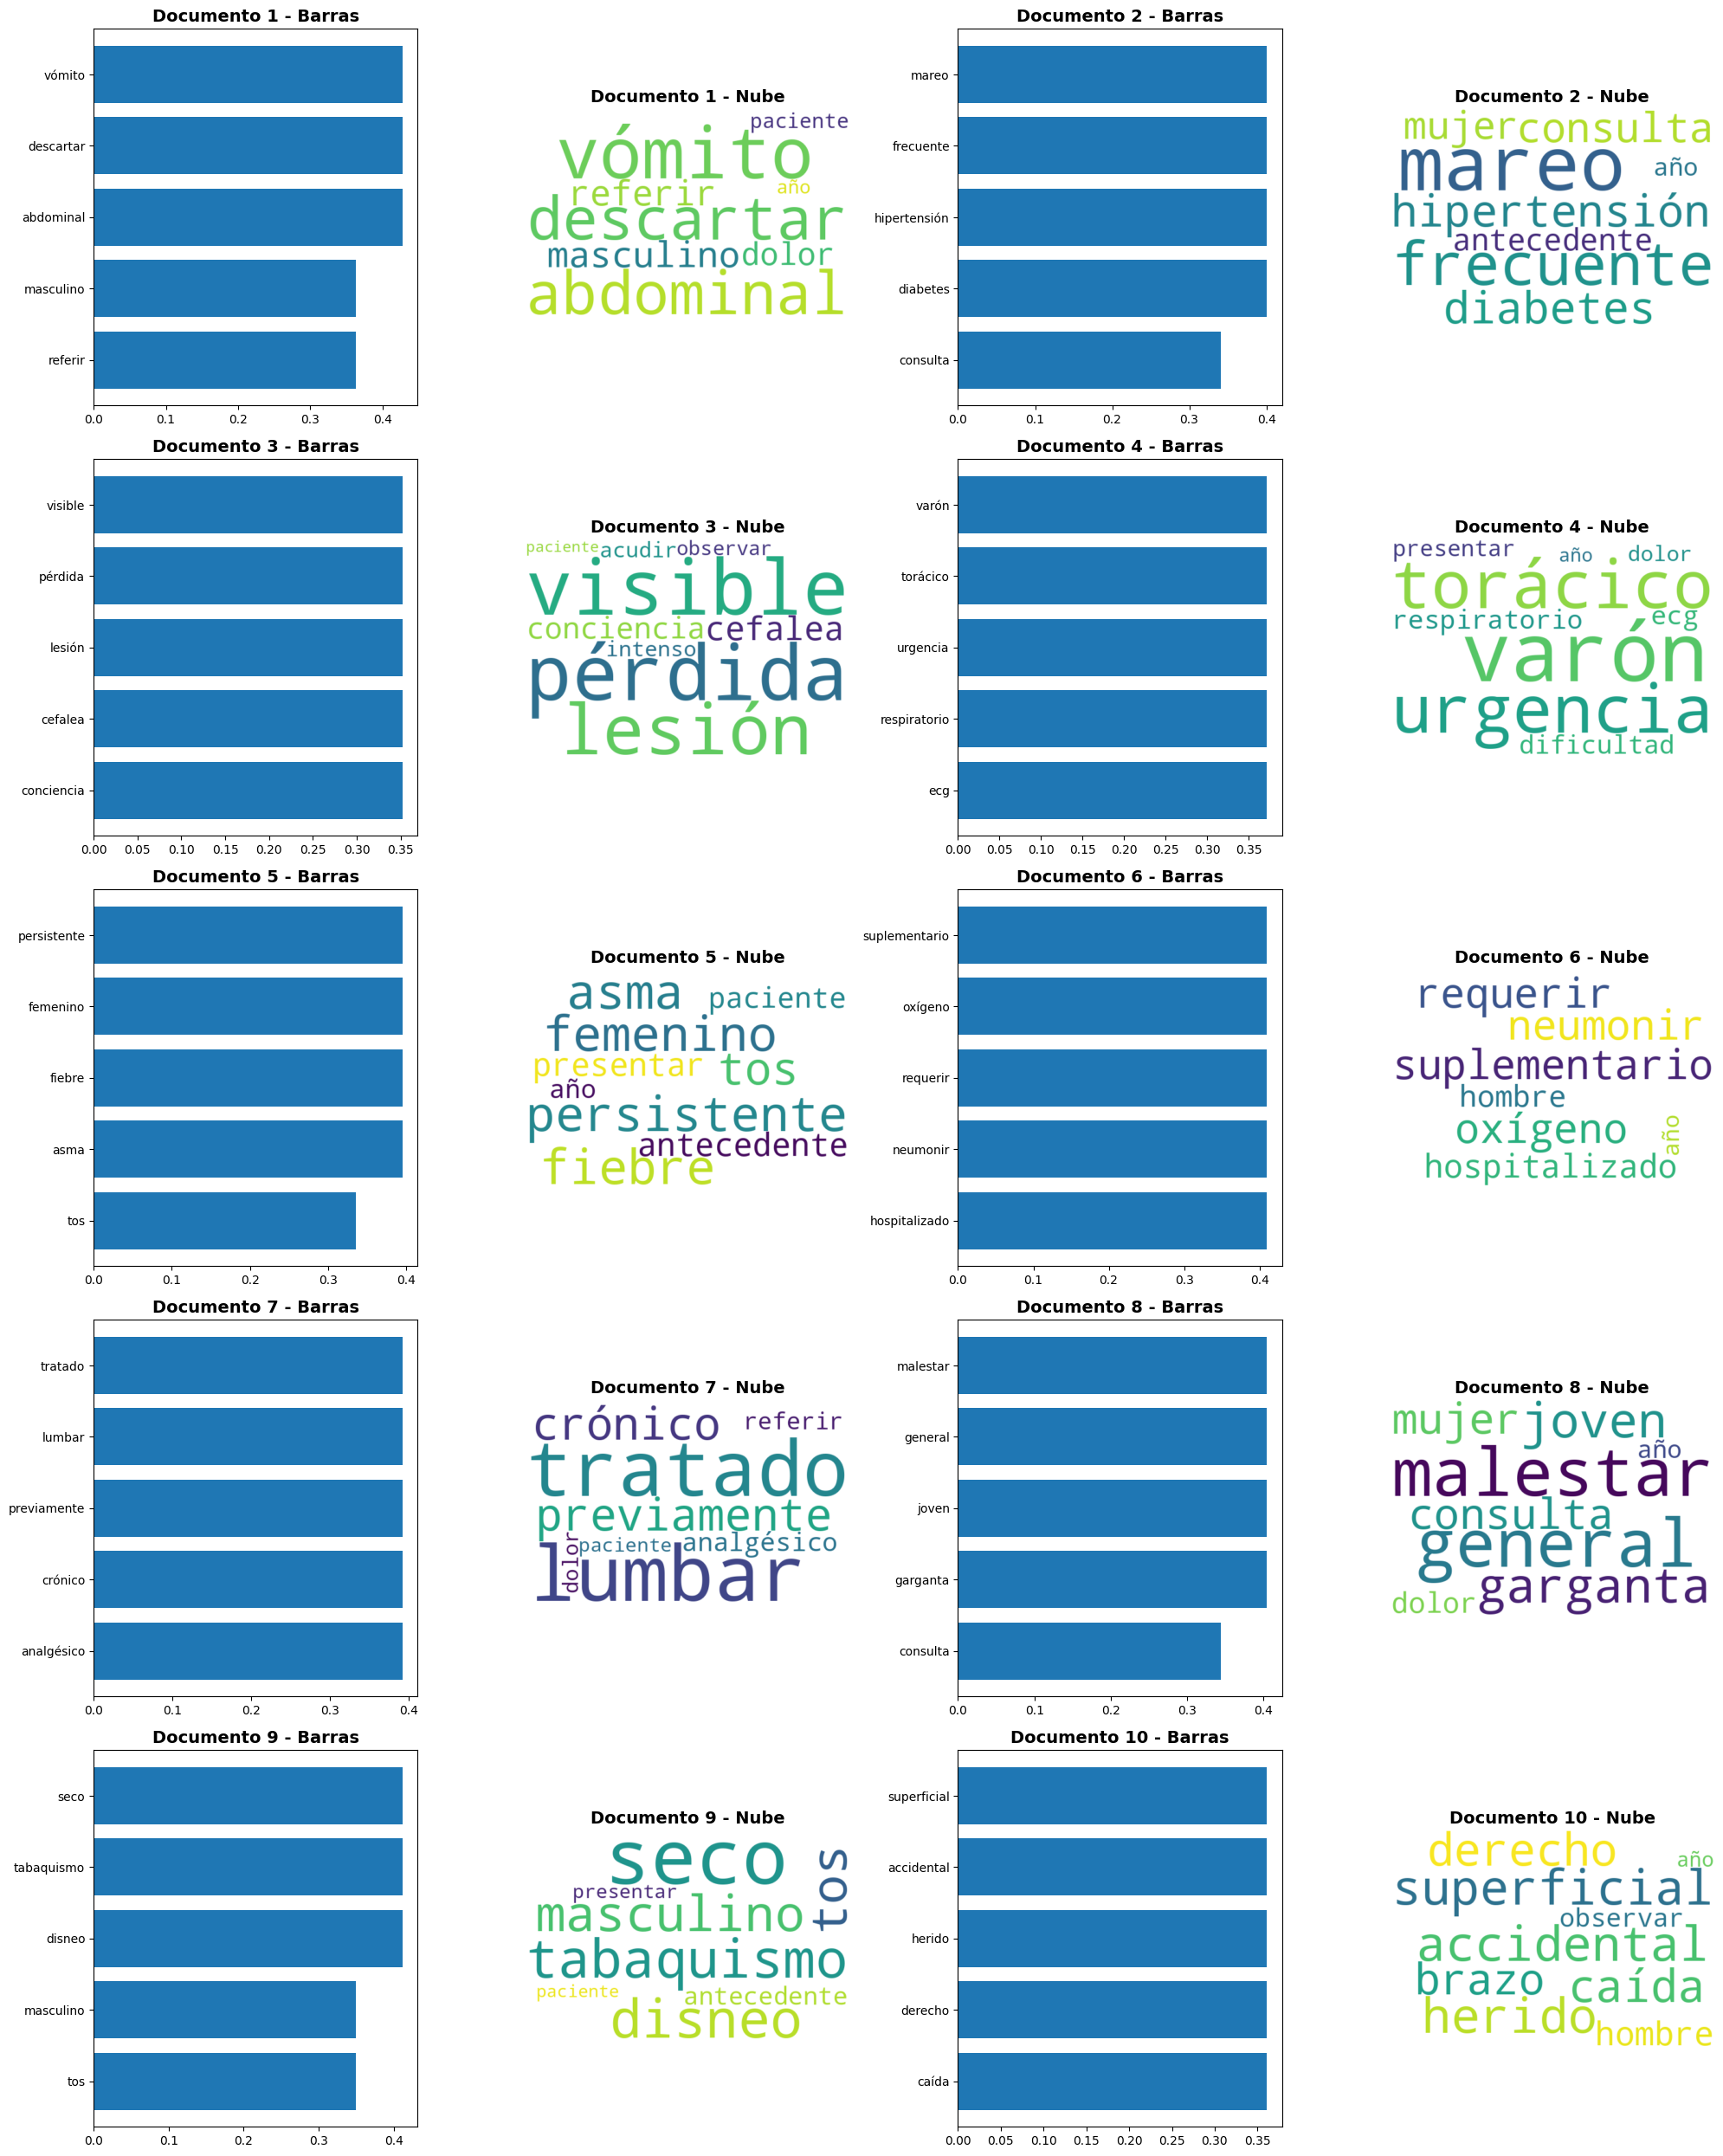

In [12]:
def barra_and_wordcloud(matrix, feature_names, top_n_barras=5, top_n_wc=10):
    """
    Genera visualizaciones combinadas (barras + nube de palabras) por documento.
    - top_n_barras: número de términos a mostrar en barras
    - top_n_wc: número de términos en la nube de palabras
    """
    n_docs = matrix.shape[0]
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # 5 filas x 4 columnas
    axes = axes.flatten()

    for i in range(n_docs):
        # === Gráfico de barras ===
        row = matrix[i].toarray().flatten()
        top_idx = row.argsort()[::-1][:top_n_barras]
        terms = [(feature_names[j], row[j]) for j in top_idx if row[j] > 0]

        if terms:
            palabras, scores = zip(*terms)
            axes[2*i].barh(palabras, scores, color="skyblue")
            axes[2*i].set_title(f"Documento {i+1} - Barras", fontsize=14, fontweight="bold")
            axes[2*i].invert_yaxis()
        else:
            axes[2*i].axis("off")

        # === Nube de palabras ===
        top_idx = row.argsort()[::-1][:top_n_wc]
        terms_wc = {feature_names[j]: row[j] for j in top_idx if row[j] > 0}

        if terms_wc:
            wc = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(terms_wc)
            axes[2*i+1].imshow(wc, interpolation="bilinear")
            axes[2*i+1].axis("off")
            axes[2*i+1].set_title(f"Documento {i+1} - Nube", fontsize=14, fontweight="bold")
        else:
            axes[2*i+1].axis("off")

    plt.tight_layout()
    plt.show()

# Uso
barra_and_wordcloud(X, vectorizer.get_feature_names_out(), top_n_barras=5, top_n_wc=10)

<u>**Análisis de términos más relevantes por documento**</u>

Los gráficos combinados muestran, para cada nota clínica, los **términos con mayor peso TF-IDF**, es decir, las palabras más representativas y distintivas de cada documento:

- **Doc_1 (dolor abdominal, vómitos)** → Destacan términos como *“abdominal”*, *“vómito”* y *“descartar”*, que reflejan el motivo de consulta principal.  
- **Doc_2 (mareos frecuentes, HTA y diabetes)** → Se resaltan *“mareo”*, *“hipertensión”* y *“diabetes”*, ligados a antecedentes crónicos y síntomas actuales.  
- **Doc_3 (cefalea intensa)** → Palabras clave como *“cefalea”*, *“pérdida”*, *“conciencia”* y *“lesión”* evidencian un cuadro neurológico agudo.  
- **Doc_4 (dolor torácico, dificultad respiratoria)** → Sobresalen *“torácico”*, *“respiratorio”* y *“urgencia”*, asociados a un cuadro cardiopulmonar.  
- **Doc_5 (asma, tos y fiebre)** → Resaltan *“asma”*, *“persistente”*, *“tos”* y *“fiebre”*, que representan un cuadro infeccioso-respiratorio.  
- **Doc_6 (neumonía, oxígeno suplementario)** → Destacan *“neumonía”*, *“oxígeno”* y *“hospitalizado”*, indicando gravedad y tratamiento.  
- **Doc_7 (dolor lumbar crónico)** → Palabras como *“lumbar”*, *“crónico”*, *“tratado”* y *“analgésico”* refuerzan un historial de dolor persistente.  
- **Doc_8 (malestar general, dolor de garganta)** → Se resaltan *“malestar”*, *“garganta”* y *“consulta”*, típicos de un cuadro infeccioso leve.  
- **Doc_9 (tos seca, disnea, tabaquismo)** → Predominan *“tos”*, *“disnea”* y *“tabaquismo”*, reflejando factores de riesgo respiratorios.  
- **Doc_10 (herida por caída accidental)** → Destacan *“herida”*, *“superficial”* y *“accidental”*, ligados al evento traumático.

**Conclusiones del análisis visual**:  
- Cada documento quedó representado por un **conjunto reducido de términos clínicamente relevantes**, confirmando la utilidad del preprocesamiento + TF-IDF.  
- La combinación de **barras** (precisión cuantitativa) y **nubes de palabras** (síntesis visual) facilita tanto la interpretación rápida como la comparación detallada.  
- Los resultados reflejan que el pipeline permite **distinguir fácilmente distintos tipos de cuadros clínicos** (digestivos, neurológicos, respiratorios, traumáticos).

### **4. Comparar el corpus original vs preprocesado**

En este paso comparamos el **corpus original** (notas sin limpiar) con el **corpus procesado** (tras limpieza, lematización y eliminación de stopwords).  

El objetivo es observar cómo cambia la estructura del texto en términos de:
- **Longitud promedio** de las notas (número de palabras por documento).  
- **Tamaño del vocabulario** (número de palabras únicas en el corpus).  
- **Cantidad total de palabras** en el conjunto de documentos.  


In [13]:
def estadisticas_textos(textos):
    longitudes = [len(t.split()) for t in textos]
    vocabulario = set(" ".join(textos).split())
    return {
        "longitud_promedio": sum(longitudes) / len(longitudes),
        "tamaño_vocabulario": len(vocabulario),
        "palabras_totales": sum(longitudes)
    }

# Corpus original (sin limpiar)
stats_original = estadisticas_textos(df["nota_original"])
# Corpus procesado
stats_procesado = estadisticas_textos(df["texto_procesado"])

print("=== Estadísticas Corpus Original ===")
print(stats_original)
print("\n=== Estadísticas Corpus Procesado ===")
print(stats_procesado)


=== Estadísticas Corpus Original ===
{'longitud_promedio': 12.8, 'tamaño_vocabulario': 85, 'palabras_totales': 128}

=== Estadísticas Corpus Procesado ===
{'longitud_promedio': 8.3, 'tamaño_vocabulario': 59, 'palabras_totales': 83}


Para complementar el análisis numérico, graficamos las métricas de ambos corpus en un **diagrama de barras**.  
Esto permite observar fácilmente las diferencias en **longitud promedio**, **tamaño de vocabulario** y **número total de palabras**.


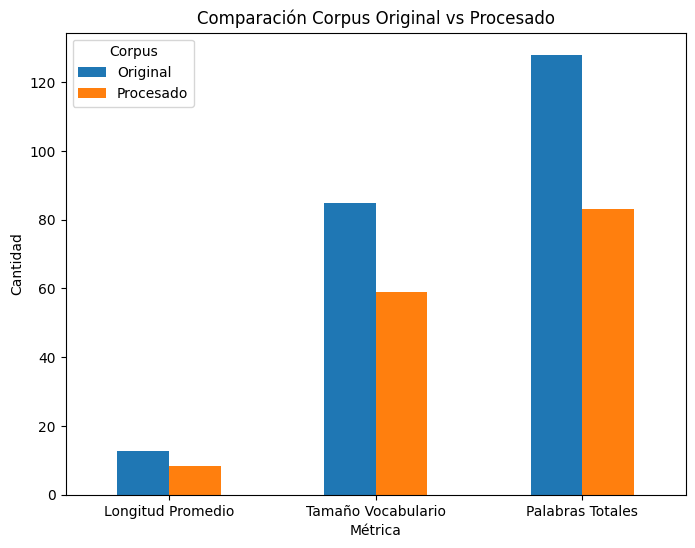

In [14]:
# Crear DataFrame comparativo
import pandas as pd

comparacion = pd.DataFrame({
    "Métrica": ["Longitud Promedio", "Tamaño Vocabulario", "Palabras Totales"],
    "Original": [stats_original["longitud_promedio"],
                 stats_original["tamaño_vocabulario"],
                 stats_original["palabras_totales"]],
    "Procesado": [stats_procesado["longitud_promedio"],
                  stats_procesado["tamaño_vocabulario"],
                  stats_procesado["palabras_totales"]]
})

# Visualización con barras
comparacion.set_index("Métrica").plot(kind="bar", figsize=(8,6), color=["#1f77b4", "#ff7f0e"])
plt.title("Comparación Corpus Original vs Procesado")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.legend(title="Corpus")
plt.show()

#### <u>**Interpretación**</u>

- La **longitud promedio** de las notas bajó de **12.8 → 8.3 palabras**, lo que indica que tras limpiar y lematizar se eliminaron stopwords y términos poco informativos.  
- El **tamaño del vocabulario** se redujo de **85 → 59 términos únicos**, dejando un conjunto más **concentrado y representativo**.  
- El **número total de palabras** pasó de **128 → 83**, lo que confirma que el preprocesamiento disminuye el ruido y la redundancia.  

<u>**Conclusión:**</u> El preprocesamiento genera un corpus más compacto y semánticamente más informativo, lo que facilita la representación y el análisis posterior de los textos clínicos.


### **Algunas conclusiones**

1. El **preprocesamiento** redujo el tamaño del vocabulario al eliminar **stopwords, signos y variaciones morfológicas**, dejando un conjunto más limpio.  
2. La **longitud promedio** de los documentos disminuyó, lo que refleja que ahora se conservan principalmente los términos más **relevantes y representativos**.  
3. La **vectorización con TF-IDF** permitió identificar de forma clara las palabras clave en cada nota clínica, resaltando síntomas y diagnósticos distintivos.  
4. Este **pipeline de limpieza + lematización + vectorización** facilita tareas posteriores como **clasificación o clustering**, ya que entrega un corpus más compacto, normalizado y libre de ruido.  



---

## ¿Por qué es importante el preprocesamiento de texto?

El **preprocesamiento** es una etapa clave en NLP porque transforma textos desordenados en datos listos para ser analizados.  
Permite **reducir ruido**, **normalizar expresiones** y destacar solo la información realmente relevante.  

En resumen: **sin un buen preprocesamiento, incluso los modelos más potentes pierden precisión y valor práctico**.